### Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#

#  Generate a DataFrame for Image Files and Their Labels

In [2]:
from pathlib import Path

#dataset_dir = Path("path/to/dataset")  # Replace with the path to your dataset
dataset_dir = Path("../Code/Rice_Image_Dataset")
classes = [d.name for d in dataset_dir.iterdir() if d.is_dir()]
#classes.remove('Rice_Citation_Request.txt')
num_classes = len(classes)

image_count = len(list(dataset_dir.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f"Number of classes: {num_classes}")
print("Classes:", classes)

Total images: 75000
Number of classes: 5
Classes: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


#

#  Generate a DataFrame for Image Files and Their Labels

In [3]:
data = []

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, img_file)
            data.append([file_path, class_name])

df = pd.DataFrame(data, columns=['Image', 'label'])

print(df.head())

                                               Image    label
0  ..\Code\Rice_Image_Dataset\Arborio\Arborio (1)...  Arborio
1  ..\Code\Rice_Image_Dataset\Arborio\Arborio (10...  Arborio
2  ..\Code\Rice_Image_Dataset\Arborio\Arborio (10...  Arborio
3  ..\Code\Rice_Image_Dataset\Arborio\Arborio (10...  Arborio
4  ..\Code\Rice_Image_Dataset\Arborio\Arborio (10...  Arborio


#

#   Exploring Dataset Distribution by Class

In [5]:
images_per_class = []
all_classes = []
for class_name in classes:
    total_images = len(os.listdir(os.path.join(dataset_dir, class_name)))
    images_per_class.append(total_images)
    all_classes.append(class_name)
    print(f'{class_name.capitalize()}: contains {total_images} images')

Arborio: contains 15000 images
Basmati: contains 15000 images
Ipsala: contains 15000 images
Jasmine: contains 15000 images
Karacadag: contains 15000 images


#

#   Distribution of Images in DataSet

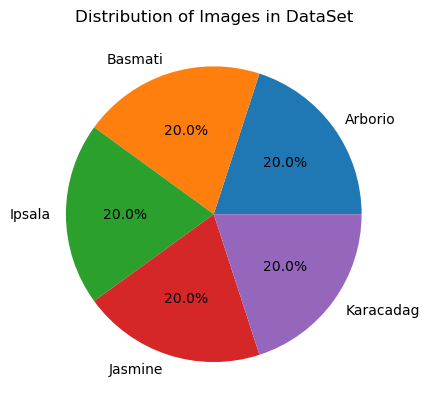

In [6]:
# Create pie chart
plt.pie(images_per_class, labels=all_classes, autopct='%1.1f%%')
plt.title('Distribution of Images in DataSet')
plt.show()

#

#  Distribution of Samples for Each Rice Class

C:\Users\Anwer.AAMD\AppData\Local\Temp\ipykernel_23520\3029864097.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', palette=colors, data=df, edgecolor="black", linewidth=1.5)


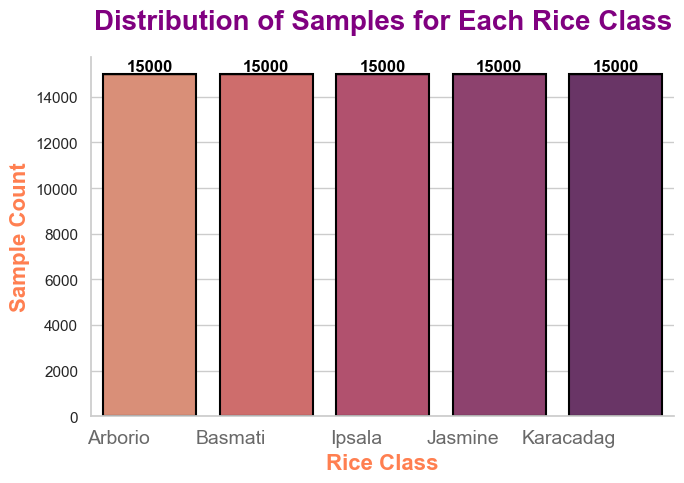

In [7]:
sns.set(style="whitegrid")
colors = sns.color_palette("flare", len(df['label'].unique())) 

plt.figure(figsize=(7, 5))
ax = sns.countplot(x='label', palette=colors, data=df, edgecolor="black", linewidth=1.5)

ax.set_title("Distribution of Samples for Each Rice Class", fontsize=20, weight='bold', color='purple', pad=20)
ax.set_xlabel("Rice Class", fontsize=16, weight='bold', color='coral')
ax.set_ylabel("Sample Count", fontsize=16, weight='bold', color='coral')

plt.xticks(ha='right', fontsize=14, color='dimgray')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black', weight='bold')

for p in ax.patches:
    ax.add_patch(plt.Rectangle((p.get_x(), p.get_height()), p.get_width(), 0.1, color='black'))

sns.despine()
plt.tight_layout()
plt.show()

#

#   Sample Images from Each Class

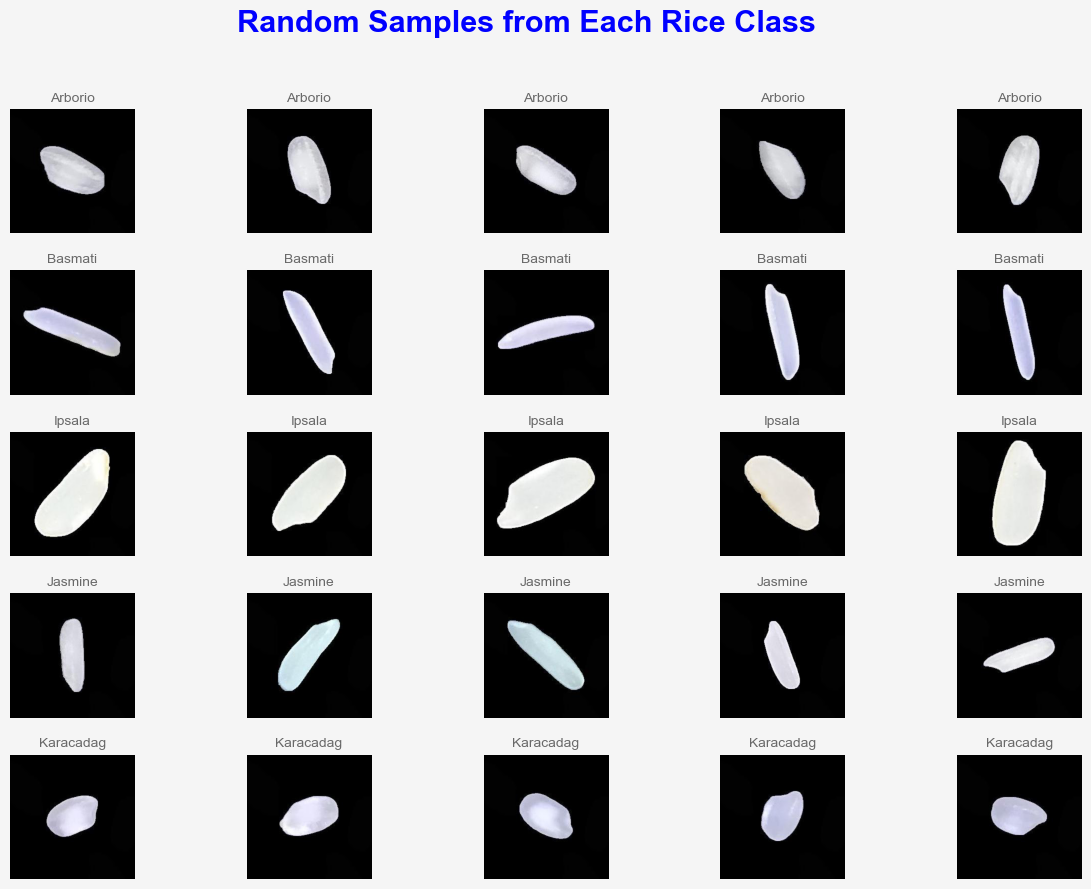

In [8]:
num_images_per_class = 5
num_classes = len(all_classes)
plt.figure(figsize=(15, 10))
plt.gcf().set_facecolor('whitesmoke')
plt.suptitle("Random Samples from Each Rice Class", fontsize=22, fontweight='bold', color='blue')

for i, class_name in enumerate(all_classes):
    # Randomly select 10 images from each class
    class_dir = f"{dataset_dir}/{class_name}"
    random_images = random.sample(os.listdir(class_dir), num_images_per_class)
    
    for j, img_name in enumerate(random_images):
        img_path = f"{class_dir}/{img_name}"
        
        img = plt.imread(img_path)
        ax = plt.subplot(num_classes, num_images_per_class, i * num_images_per_class + j + 1)
        ax.imshow(img)
        ax.set_title(class_name, fontsize=10, color='dimgray')
        ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

#

#  Creating Train, Validation, and Test Datasets for Rice Image Classification

In [9]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Image'], df['label'], test_size=0.2, random_state=42)

In [10]:
# Creating DataFrames for training and testing data
df_train = pd.DataFrame({'Image': X_train, 'label': y_train})
df_test = pd.DataFrame({'Image': X_test, 'label': y_test})

In [11]:
# Encoding the labels
encoder = LabelEncoder()
df_train['label'] = encoder.fit_transform(df_train['label'])
df_test['label'] = encoder.transform(df_test['label'])

In [12]:
# Converting labels to strings
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [13]:
# Setting up ImageDataGenerator with augmentation
image_size = (250, 250)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizing pixel values
    rotation_range=45,  # Randomly rotating images
    width_shift_range=0.2,  # Randomly shifting images horizontally
    height_shift_range=0.2,  # Randomly shifting images vertically
    shear_range=0.2,  # Shearing transformations
    zoom_range=0.2,  # Randomly zooming into images
    horizontal_flip=True,  # Randomly flipping images horizontally
    fill_mode='nearest'  # Filling new pixels with nearest pixel values
)


In [14]:
# Creating a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='Image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    shuffle=True  # Shuffling the training data
)


Found 60000 validated image filenames belonging to 5 classes.


In [15]:
# Creating a generator for the testing data
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='Image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Multi-class classification
    shuffle=False  # No shuffling for testing data
)

Found 15000 validated image filenames belonging to 5 classes.


#

#  Creating the Convolutional Neural Network (CNN)

In [17]:
# Define the model
cnn = tf.keras.models.Sequential()

# 1: Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(250, 250, 3)))

# 2: Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# 3: Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# 4: Flattening
cnn.add(tf.keras.layers.Flatten())

# 5: Full connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# 6: Output layer
cnn.add(tf.keras.layers.Dense(units=5, activation='softmax'))  # # Changing the number of outputs as the number of classes

#  Check the structure of the Sequential model
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 248, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 124, 124, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 238144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    30,482,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,502,597 (116.36 MB)

 Trainable params: 30,502,597 (116.36 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compile the model
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Training the model with the callbacks
fit_model = cnn.fit(
    train_generator,
    epochs=10,  
    validation_data=test_generator,
    callbacks=[early_stopping, checkpoint]
)

c:\Users\Anwer.AAMD\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7235 - loss: 0.6946
Epoch 1: val_loss improved from inf to 0.22877, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7417s 4s/step - accuracy: 0.7236 - loss: 0.6945 - val_accuracy: 0.9130 - val_loss: 0.2288
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9202 - loss: 0.2132
Epoch 2: val_loss improved from 0.22877 to 0.13206, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3712s 2s/step - accuracy: 0.9202 - loss: 0.2132 - val_accuracy: 0.9533 - val_loss: 0.1321
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9496 - loss: 0.1396
Epoch 3: val_loss did not improve from 0.13206
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2358s 1s/step - accuracy: 0.9496 - loss: 0.1396 - val_accuracy: 0.9246 - val_loss: 0.1897
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.9600 - loss: 0.1122 
Epoch 4: val_loss improved from 0.13206 to 0.06809, saving model to best_m

In [20]:
test_loss, test_accuracy = cnn.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

469/469 ━━━━━━━━━━━━━━━━━━━━ 258s 551ms/step - accuracy: 0.9852 - loss: 0.0499
Test Loss: 0.04956769943237305
Test Accuracy: 0.9840666651725769


469/469 ━━━━━━━━━━━━━━━━━━━━ 259s 553ms/step
              precision    recall  f1-score   support

     Arborio       0.99      0.97      0.98      2997
     Basmati       0.99      0.99      0.99      2995
      Ipsala       1.00      1.00      1.00      3083
     Jasmine       0.96      0.98      0.97      2996
   Karacadag       0.99      0.99      0.99      2929

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



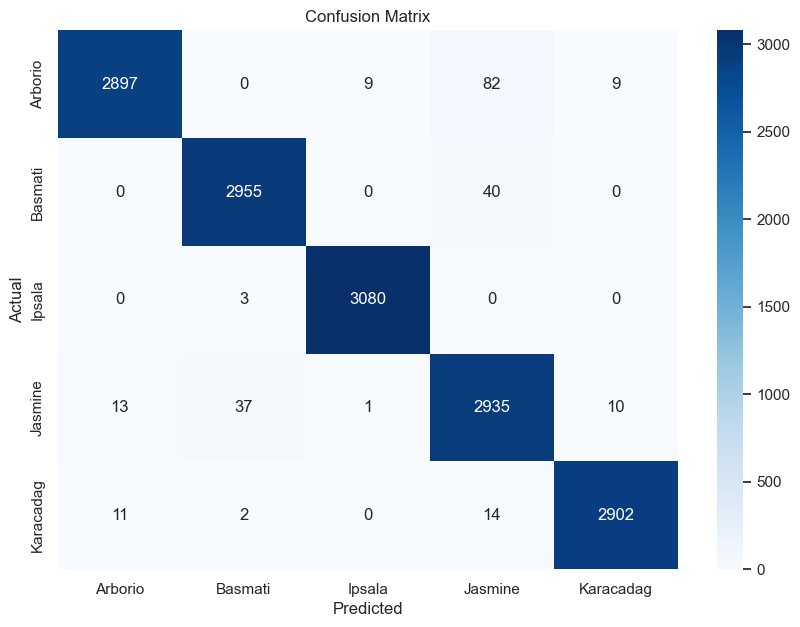

In [21]:

from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = cnn.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

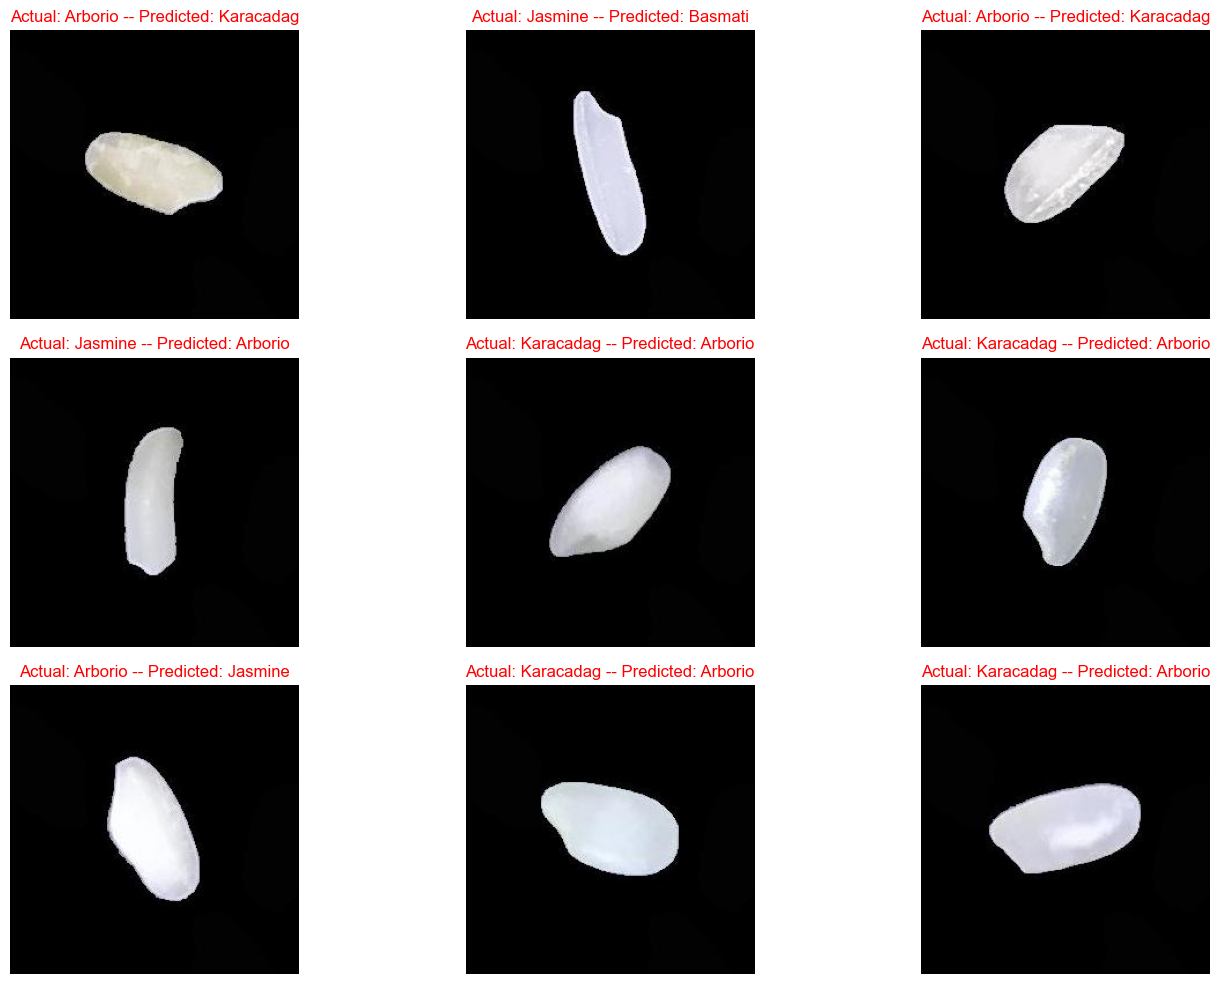

In [29]:
# Displaying Misclassified Images
errors = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(15, 10))
for i, error in enumerate(errors[:9]):  # Displaying the first 9 mistakes
    plt.subplot(3, 3, i + 1)
    img_path = test_generator.filepaths[error]
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(f"Actual: {encoder.classes_[y_true[error]]} -- Predicted: {encoder.classes_[y_pred_classes[error]]}",
              color='red' if y_true[error] != y_pred_classes[error] else 'green')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [30]:
# Printing the total number of misclassifications
total_errors = len(errors)
print(f"Total number of misclassified images: {total_errors}")

Total number of misclassified images: 231


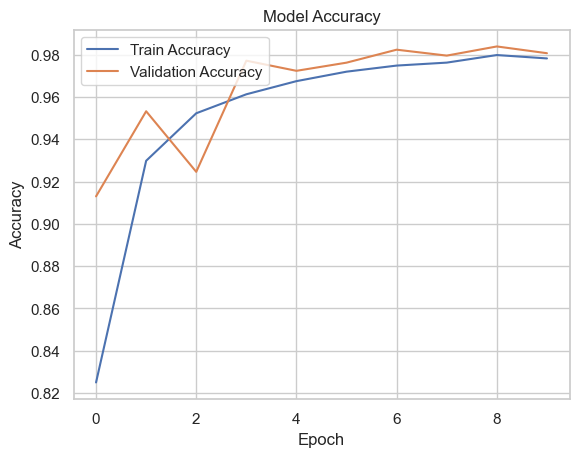

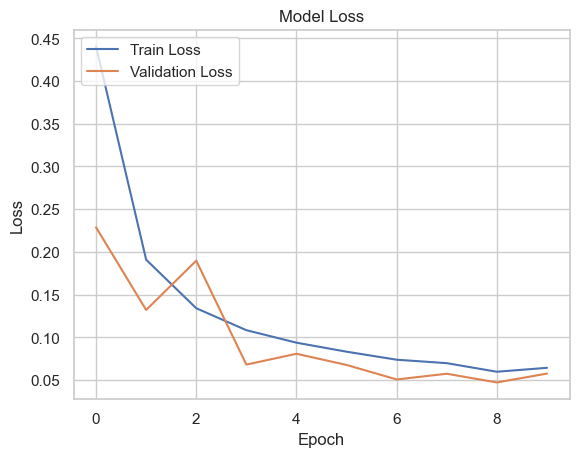

In [32]:
# Plot Accuracy
plt.plot(fit_model.history['accuracy'], label='Train Accuracy')
plt.plot(fit_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot Loss
plt.plot(fit_model.history['loss'], label='Train Loss')
plt.plot(fit_model.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [33]:
# Save model architecture as JSON file
model_json = cnn.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights with correct filename
cnn.save_weights("model_weights.weights.h5")
print("Model and weights saved successfully.")

Model and weights saved successfully.


In [34]:
from keras.models import model_from_json

# Load model architecture
with open("model_architecture.json", "r") as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)

# Load model weights
loaded_model.load_weights("model_weights.weights.h5")
print("Model loaded successfully.")

# Compile loaded model (necessary to prepare the model for prediction)
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model loaded successfully.
